### Building a Bridge: From Fires to People

The goal of this part is to use basin hydrology to connect fire risk and flood risk and then that enhanced flood risk to social vulnerability. 

#### Step 0: Step Up

The following code:
* imports libraries
* addresses an error
* imports the data with a common coordinate system

In [1]:
# Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from shapely.validation import explain_validity

# Address Conda <--> PROJ error
import os; os.environ['PROJ_LIB'] = '/path/to/env/share/proj'
# Source: https://gis.stackexchange.com/questions/364421/how-to-make-proj-work-via-anaconda-in-google-colab

# Import fire data, set coordinates to 6933
f=gpd.read_file("../Final/data/LAC_fires.geojson").to_crs(epsg=6933)

# Set a bounding box for hydrology data
bbox = (-118.9441,32.8065,-117.6447,34.8227)
# Source: https://observablehq.com/@rdmurphy/u-s-county-bounding-boxes-by-state

# Import basin data
b=gpd.read_file("../Final/data/BasinATLAS_Data_v10.gdb.zip", driver='FileGDB', layer='BasinATLAS_v10_lev12',bbox=bbox)
b=b.to_crs(6933)

# Drop islands
b = b[b['HYBAS_ID']!=7120055730]
b = b[b['HYBAS_ID']!=7120055740]

# Import flood data
d = gpd.read_file('../Final/data/flood_r.geojson').to_crs(epsg=6933)

# Import SVI data (census tracts)
c=gpd.read_file("../Final/data/Los_Angeles_County_CVA_Social_Vulnerability_Index.geojson").to_crs(epsg=6933)

# Import neighborhood boundaries
n=gpd.read_file("../Final/data/neighborhood.geojson").to_crs(epsg=6933)

#### Step 1: Determine the cumulative fraction of each basin that has burned

This part overlaps fires from the fire maps with each basin from the basin maps to calculate the cumulative fraction of each basin that has historically burned.

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


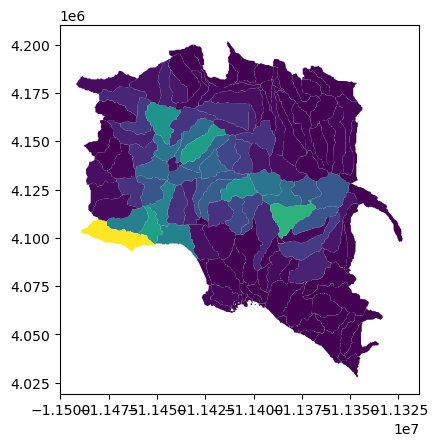

In [2]:
# Make a list of basins
basins = []
for i in list(range(0,b.shape[0])):
    basins.append([b.iloc[i]])

# Make a list of fires
fires = []
for i in list(range(0,f.shape[0])):
    fires.append([f.iloc[i]])
    
# Functions to find cumulative burned area
def f1(a,b):
    return a[0]["geometry"].intersection(b[0]["geometry"]).area
def f2(b,aa):
    return sum([f1(a,b) for a in aa])
def f3(aa,bb):
    return [f2(b,aa) for b in bb]

# Add the cumulative burned area to each basin in the dataframe and map
burned = f3(fires,basins) # (the list 'burned' will be needed later)
b["burnt"] = burned
b.plot(column=b["burnt"])
plt.savefig("burnt.png")

#### Step 2: Calculate for each basin the total burnt area in the basin and *upstream* of the basin.

The basin data already have a column providing the immediate *downstream* basin for each basin. This section:
* identifies the immediate *upstream* basin(s)
* idenfities all basins upstream (anywhere in the network; early work showed 9-10 steps is sufficient)
* calculates the fraction of upstream basin area that has burned

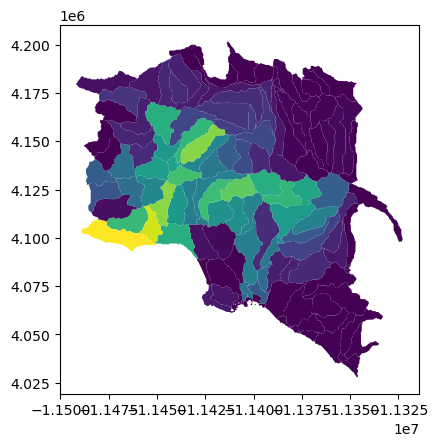

In [3]:
# Make a list of basin ids
def get_id(basin):
    return basin[0][0]
ids = [get_id(basin) for basin in basins]

# Make a list of each basin's downstream basin
def get_down(basin):
    return basin[0][1]
downs = [get_down(basin) for basin in basins]

# Create an identity matrix for holding upstream connections (to be populated)
up = np.identity(len(basins))

# Use `downs` list to set to 1 any `[a,b]` where basin `b` flows into basin `a`.
for dn in range(0,len(downs)):
    if downs[dn]!=0:
        try:
            up[ids.index(downs[dn])][dn]=1
        except:
            1+1
        
# Create a function to lookup immediate upstream basin(s)
def subit(z):
    return [i for i, x in enumerate(up[z]) if x == 1]
# Source of the above line syntax: https://stackoverflow.com/questions/57970751/python-what-does-i-for-i-mean

# Work back through the network
for i0 in range(0,len(basins)):
    x = list([i0])
    i1 = subit(i0)
    for z in i1:
        x.append(z)
        i2 = subit(z)
        for z in i2:
            x.append(z)
            i3 = subit(z)
            for z in i3:
                x.append(z)
                i4 = subit(z)
                for z in i4:
                    x.append(z)
                    i5 = subit(z)
                    for z in i5:
                        x.append(z)
                        i6 = subit(z)
                        for z in i6:
                            x.append(z)
                            i7 = subit(z)
                            for z in i7:
                                x.append(z)
                                i8 = subit(z)
                                for z in i8:
                                    x.append(z)
                                    i9 = subit(z)
                                    for z in i9:
                                        x.append(z)
                                        i10 = subit(z)
                                        for z in i10:
                                            x.append(z)
    up[i0][x]=1
    
# Find the total area burned in and upstream of each basin
def calc_burnup(i):
    return sum(np.multiply(up[i],burned))

# Calculate fraction upstream burned and plot
burnup = [calc_burnup(i) for i in range(0,len(basins))]
b["burnup"]=burnup
b["fburnt"]=b["burnup"]/(b["UP_AREA"]*1000000)
b.plot(column="fburnt")
plt.savefig("fburnt.png")

This map shows which basins are most vulnerable to fire-exacerbated discharge.

#### Step 3: Map fire-related discharge enchancement to current flood risk.

This part quantifies flood-risk zones by their fire-enhanced discharge risk.

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


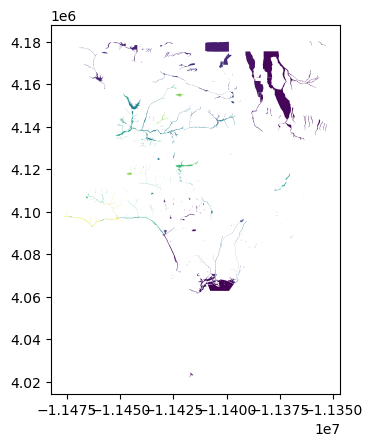

In [4]:
# Make a list of flood zones
floods = []
for i in list(range(0,d.shape[0])):
    floods.append([d.iloc[i]])

# Make a new basin list (with burned info)
new_basins = []
for i in list(range(0,b.shape[0])):
    new_basins.append([b.iloc[i]])
    
# Define functions to multiply each area of intersection (flood risk zone * enhanced basin)
# by the fire-exacerbated discharge enhancement for that basin
def f4(a,b):
    return (a[0]["geometry"].intersection(b[0]["geometry"])).area
def f5(b,aa):
    return sum([f4(a,b)*a[0]["fburnt"] for a in aa])
def f6(aa,bb):
    return [f5(b,aa)/b[0]["geometry"].area for b in bb]

# Calculate the fire-enhanced flood risk in each flood zone and plot
enhanced=f6(new_basins,floods)
d["enhanced"]=enhanced
d.plot(column="enhanced")
plt.savefig("flood_enhance.png")

#### Step 4: Allocate enhanced flood risks to census tracts

This part assigns enhanced flood risk to census tracts based on the fraction of the census tract that is in the flood zone and the magnitude of the fire-enhancement of flood risk.

In [ ]:
# Make list of floods (with fire-enhancements)
new_floods = []
for i in list(range(0,d.shape[0])):
    new_floods.append([d.iloc[i]])
    
# Make list of tracts
tracts = []
for i in list(range(0,c.shape[0])):
    tracts.append([c.iloc[i]])

# Spatial aggregating functions
def f7(a,b):
    return (a[0]["geometry"].intersection(b[0]["geometry"])).area
def f8(b,aa):
    return sum([f7(a,b)*a[0]["enhanced"] for a in aa])
def f9(aa,bb):
    return [f8(b,aa) for b in bb]

# Calculate the area-and-fire-enhancement-scaled impact on each tract and plot
impact=f9(new_floods,tracts)
c["impact"]=impact
areas = [tract[0]["geometry"].area for tract in tracts]
c["area"]=areas
c["scaled_impact"]=c["impact"]/c["area"]
c.plot(column="scaled_impact")

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


These are the census tracts in LA County with flood risk whose risk is most sensitive to fire-exacerbation, prior to incorporating population vulnerability.

#### Step 5: Integrate with social vulnerability scores

This part multiplies percentile fire-enhanced-flood risk with percentile SVI and plots the result by census tract and neighborhood, calculating values for neighborhoods by area-and-population-weighted averaging of tracts.

In [ ]:
# First, a function to calculate percentiles:
# https://stackoverflow.com/questions/44607537/convert-array-into-percentiles
def percentile(stuff):
    arr_sorted =  sorted(stuff)
    s = pd.Series(stuff)
    return s.apply(lambda x: percentileofscore(arr_sorted, x))

#Calculate the product of scaled impact percentile and SVI percentile
c["FEFxCES"]=percentile(c["scaled_impact"])*percentile(c["SoVI_Score"])

# Make a list of neighborhoods
hoods = []
for i in list(range(0,n.shape[0])):
    hoods.append([n.iloc[i]])

# Remove neighborhoods with invalid geometry (nested shells)
valid_geo=[explain_validity(hood[0]["geometry"])=='Valid Geometry' for hood in hoods]
# Previous line inspired by: https://gis.stackexchange.com/questions/413670/turn-a-multipolygon-with-nested-shells-into-a-polygon-with-holes?rq=1
n["valid"]=valid_geo
m=n[n["valid"]==True]

# Remake list of neighborhoods
hoods = []
for i in list(range(0,m.shape[0])):
    hoods.append([m.iloc[i]])

# Make list of tracts (with fire-enhanced-flood risk)
tracts = []
for i in list(range(0,c.shape[0])):
    tracts.append([c.iloc[i]])
    
# Define aggregation functions for area-and-population-weighted averaging of tracts --> neighborhoods
def f11(a,b):
    return (a[0]["geometry"].intersection(b[0]["geometry"])).area
def f12(b,aa):
    return sum([f11(a,b)*a[0]["FEFxCES"]*a[0]["Population"] for a in aa])
def f13(aa,bb):
    return [f12(b,aa)/b[0]["geometry"].area for b in bb]
def f14(a,b):
    return (a[0]["geometry"].intersection(b[0]["geometry"])).area
def f15(b,aa):
    return sum([f14(a,b)*a[0]["Population"] for a in aa])
def f16(aa,bb):
    return [f15(b,aa)/b[0]["geometry"].area for b in bb]

# Compute ratio (to complete population-averaging)
x=f13(tracts,hoods)
y=f16(tracts,hoods)
ratios = []
for i in list(range(0,m.shape[0])):
    ratios.append(x[i]/y[i])
m["mean_FEFxCES"]=ratios

# Plot census tract and neighborhood results
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
ax1 = c.plot(ax=ax1, column='FEFxCES', legend=True)
ax2 = m.plot(ax=ax2, column='mean_FEFxCES', legend=True)

These maps suggest census tracts and neighborhoods with flood risk that have high combinations of current flood risk, fraction of upstream land has historically burned, and social vulnerability. Flood risk in these tracts perhaps should be re-evaluated in light of the potential for upstream burning to enhance water discharge and flood protection and resilience measures may be particularly valuable in these areas.